In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [3]:
data = pd.read_csv('ab_browser_test.csv')

### Описание данных:
* userID: уникальный идентификатор пользователя
* browser: браузер, который использовал userID
* slot: в каком статусе пользователь участвовал в исследовании (exp = видел
  измененную страницу, control = видел неизменную страницу)
* n_clicks: количество кликов, которые пользоваль совершил за n_queries
* n_queries: количество запросов, который совершил userID, пользуясь браузером
  browser
* n_nonclk_queries: количество запросов пользователя, в которых им не было
  совершено ни одного клика

In [3]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data.shape

(566134, 6)

In [5]:
# 1 Вопрос. Насколько в группе exp больше кликов, чем в control. OK
print 'Exp click = %i'% data.n_clicks[data.slot=='exp'].sum()
print 'Control click = %i'% data.n_clicks[data.slot=='control'].sum()
print '%.3f%%' % ((float(data.n_clicks[data.slot=='exp'].sum()) /
data.n_clicks[data.slot=='control'].sum()-1) * 100 )

Exp click = 3261823
Control click = 3210027
1.614%


### 2 Вопрос

In [6]:
def get_bootstrap_samples_medians(data, n_samples):
    med = []
    for i in range(n_samples):
        indices = np.random.randint(0, len(data),  len(data))
        samples = data[indices]
        med.append(np.median(samples))
    return np.array(med)
def get_bootstrap_samples_means(data, n_samples):
    mean = []
    for i in range(n_samples):
        indices = np.random.randint(0, len(data),  len(data))
        samples = data[indices]
        mean.append(np.mean(samples))
    return np.array(mean)
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
exp_cl = data.n_clicks[data.slot=='exp'].values
control_cl = data.n_clicks[data.slot=='control'].values

In [8]:
exp_medians = get_bootstrap_samples_medians(exp_cl,1000)
control_medians = get_bootstrap_samples_medians(control_cl,1000)

In [9]:
exp_means = get_bootstrap_samples_means(exp_cl,1000)
control_means = get_bootstrap_samples_means(control_cl,1000)

In [10]:
# OK
print '95% интервал разницы медиан: ', stat_intervals(exp_medians-control_medians,0.05)
print '95% интервал разницы средних: ', stat_intervals(exp_means-control_means,0.05)

95% интервал разницы медиан:  [ 1.  1.]
95% интервал разницы средних:  [ 0.20119929  0.40128674]


### 4 Вопрос

In [11]:
def get_bootstrap_means_mse(data, n_samples):
    mean = []
    mse = []
    np.random.seed(0)
    for i in range(n_samples):
        indices = np.random.randint(0, len(data),  len(data))
        samples = data[indices]
        m = np.mean(samples)
        ms = np.sum((samples - m)**2)
        mean.append(m)
        mse.append(ms)
    return (np.array(mean),np.array(mse))

In [12]:
control_boot_means, control_boot_chi_squeared = get_bootstrap_means_mse(
    data.n_clicks[data.slot=='control'].values,500)

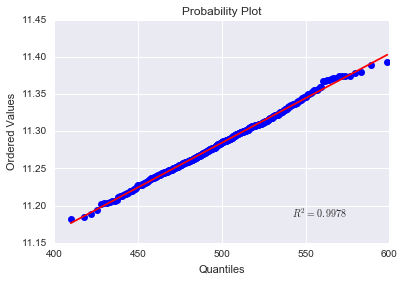

In [13]:
(osm1, osr1),(slope1, intercept1, r1) = scipy.stats.probplot(control_boot_means,
                                                    dist='chi2',sparams=(499),plot=plt)

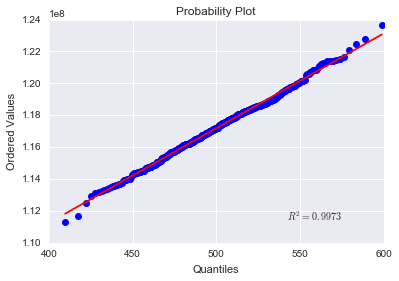

In [14]:
(osm2, osr2),(slope2, intercept2, r2) = scipy.stats.probplot(control_boot_chi_squeared,
                                                    dist='chi2',sparams=(499),plot=plt)

In [15]:
#OK
print r1**2
print r2**2

0.997781147078
0.997285184825


### 5 Вопрос

In [16]:
exp_data = data[data.slot == 'exp']
control_data = data[data.slot == 'control']

In [17]:
print exp_data.shape
print control_data.shape

(281580, 6)
(284554, 6)


In [18]:
exp = []
for x in exp_data.userID.value_counts()[exp_data.userID.value_counts() > 1].keys():
    exp.append(exp_data[exp_data.userID == x].n_clicks.sum())
    exp_data = exp_data.drop(exp_data[exp_data.userID == x].index)
exp += exp_data.n_clicks.values.tolist()
exp = np.array(exp)

In [19]:
control = []
for x in control_data.userID.value_counts()[control_data.userID.value_counts() > 1].keys():
    control.append(control_data[control_data.userID == x].n_clicks.sum())
    control_data = control_data.drop(control_data[control_data.userID == x].index)
control += control_data.n_clicks.values.tolist()
control = np.array(control)

In [20]:
exp_means = get_bootstrap_samples_means(exp,1000)
control_means = get_bootstrap_samples_means(control,1000)

In [21]:
scipy.stats.mannwhitneyu(exp.astype(float),control.astype(float))

MannwhitneyuResult(statistic=38901259929.0, pvalue=nan)

### 6 Вопрос

In [231]:
import statsmodels.sandbox.stats.multicomp as mmc

In [5]:
p_vals = []
for i in range(len(data.browser.value_counts())):
    exp_br = exp_data[exp_data.browser == data.browser.value_counts().keys()[i]].n_clicks.values
    control_br = control_data[control_data.browser == data.browser.value_counts().keys()[i]].n_clicks.values
    p_vals.append(scipy.stats.mannwhitneyu(exp_br.astype(float),control_br.astype(float)).pvalue)

NameError: name 'exp_data' is not defined

In [4]:
from scipy import stats

In [6]:
brows = pd.DataFrame(columns=["browser", "p"])
for browser in data.browser.unique():
    brows = brows.append({"browser": browser, "p": stats.mannwhitneyu(data[(data["browser"]==browser) & (data["slot"]=="exp")].n_clicks, data[(data["browser"]==browser) & (data["slot"]=="control")].n_clicks)[1]}, ignore_index=True)

In [7]:
brows

,browser,p
0,Browser #2,0.019659
1,Browser #4,NaN
2,Browser #14,0.000000
3,Browser #17,NaN
4,Browser #20,0.424176
5,Browser #22,0.061341


In [10]:
data[(data["browser"]=="Browser #4") & (data["slot"]=="exp")].n_clicks.shape

(78152,)

In [240]:
p_vals

[nan, nan, 0.0034661704715809294, nan, 0.41830840885092213, nan]

In [232]:
mmc.multipletests(p_vals, method='holm')

(array([False, False,  True, False, False, False], dtype=bool),
 array([        nan,         nan,  0.02079702,         nan,  1.        ,
                nan]),
 0.008512444610847103,
 0.008333333333333333)